In [1]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns

import imp
imp.reload(wind)
import wind

import transdist

NameError: name 'wind' is not defined

In [19]:
import gmaps
import os
gmaps.configure(api_key=os.environ["GOOGLE_API_KEY"])
#import json



In [295]:
restricted_gpd = gpd.read_file('data/windpro_all_restricted_lands/windpro_all_restricted_lands.shp')
restricted_gpd = restricted_gpd[restricted_gpd['geometry'].apply(
    lambda x: x.bounds[1] < 42 and x.bounds[0] < -114
)]
print(len(restricted_gpd))

3043


In [287]:
restricted_gpd['geometry'].iloc[0].bounds

(-118.25278124934356,
 35.36312015844553,
 -118.23485724932681,
 35.37772715878291)

In [281]:
ca_urban = np.load('data/cal_urban.npy')

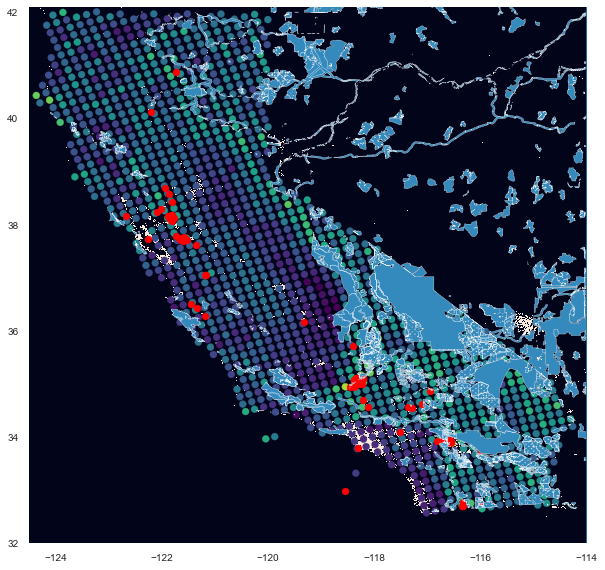

In [302]:
fig,ax = plt.subplots(figsize=(10,10))
#ca_gpd.plot(color='white',edgecolor='black',ax=ax,zorder=-5)
ax.axvline(-114)

plt.scatter([x[1] for x in grid_point_list],[x[0] for x in grid_point_list],
            c=data_df['wind'],cmap='viridis')
plt.scatter(swp_df['longitude'],swp_df['latitude'],c='red')

#grid =
#ax.set_ylim(37,39)
#ax.set_xlim(-123,-121)
restricted_gpd.plot(ax=ax)
ax.imshow(ca_urban,extent = (-124.5,-114,32,42.1),interpolation='none')

In [22]:
import geopandas as gpd
from shapely.geometry import Point
usa_gpd = gpd.read_file('maps/states_21basic/states.shp')
ca_gpd = usa_gpd[usa_gpd.STATE_ABBR == 'CA']
ca_gpd

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
24,California,25,06,Pacific,CA,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823..."


In [209]:
from shapely.geometry import Polygon
def in_gdf_geo(latlon,gdf):
    pt = Point(*latlon[::-1])
    for geo in gdf['geometry']:
        if in_multipoly_or_poly(pt,geo):
            return True
    return False
def in_multipoly(pt,mp):
    for p in mp:
        if pt.within(p):
            return True
    return False
def in_multipoly_or_poly(pt,geo):
    if type(geo) == Polygon:
        if pt.within(geo):
            return True
    else:
        if in_multipoly(pt,geo):
            return True
    return False
def in_states(latlon,usa_gpd,states):
    pt = Point(*latlon[::-1])
    if type(states) == str:
        if states == 'all':
            states = usa_gpd.STATE_ABBR
    for state in states:
        state_geo = usa_gpd[usa_gpd.STATE_ABBR == state]['geometry'].iloc[0]
        if in_multipoly_or_poly(pt,state_geo):
            return True
    return False

## specify grid manually

In [208]:
grid_div = 20
#lat_range = np.linspace(32.5,transdist.MAX_LAT,grid_div)
#lon_range = np.linspace(-118.5,-114,grid_div)
lat_range = np.linspace(32.5,42,grid_div)
lon_range = np.linspace(-125.5,-113.5,grid_div)
point_grid = np.meshgrid(lat_range,lon_range,indexing='ij')
grid_point_list = [(lat,lon) for lat,lon in zip(point_grid[0].ravel(),point_grid[1].ravel())]
#filter out points not in states
grid_point_list = [pt for pt in grid_point_list
                   if in_states(pt,usa_gpd,['CA']) and (not in_gdf_geo(pt,restricted_gpd))]
print(len(grid_point_list))
grid_layer = gmaps.symbol_layer(
    grid_point_list, fill_color="red", stroke_color="red", scale=3
)

NameError: name 'in_gdf_geo' is not defined

## use subset of nrel usa coords

In [29]:
tuple(coords.ravel()[1])[::-1]

(-121.161987, 30.465576)

In [386]:
coords[0,0]

(30.443253, -121.241516)

In [389]:
coords.shape

(94, 63)

In [390]:
%time np.vectorize(lambda p: not in_gdf_geo(tuple(p),restricted_gpd))(coords[:5,:])
#np.vectorize(lambda p: not in_gdf_geo(tuple(p),restricted_gpd))(coords[:5,:5])

CPU times: user 8.5 s, sys: 45.3 ms, total: 8.55 s
Wall time: 8.62 s


array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True],
    

In [400]:
def fun_if(f,x,b):
    if b:
        return f(x)
    else:
        return False

downsamp = 2
usa_coords = np.load('nrel-coords.npy')
coords = usa_coords[550:1300:4,300:800:4][::downsamp,::downsamp]
#filter by state
#is_in_state = np.vectorize(lambda p: in_states(tuple(p),usa_gpd,['CA']))(coords)
#is_in_restricted = np.vectorize(lambda p: in_gdf_geo(tuple(p),restricted_gpd))(coords)
is_in_valid_loc = is_in_state & ~is_in_restricted
#grid_point_list = [tuple(pt) for pt in coords.ravel()[::4] if in_states(tuple(pt),usa_gpd,['CA'])]
grid_point_list = coords[is_in_valid_loc].ravel()
len(grid_point_list)

1259

In [214]:
grid_point_list = coords[is_in_state & is_not_in_restricted].ravel()
len(grid_point_list)

317

In [215]:
grid_layer = gmaps.symbol_layer(
    grid_point_list, fill_color="red", stroke_color="red", scale=3
)

map

In [216]:
fig = gmaps.figure(
    layout={
        'width': '800px',
        'height': '600px',
    })
fig.add_layer(grid_layer)
fig

Figure(layout=FigureLayout(height='600px', width='800px'))

## make calls to nrel for data

In [8]:
nrel = wind.setup_nrel()

In [10]:
features = ['elevation','mean_wind_speed','mean_cubed_wind_speed',
            'temperature','pressure','precipitation']

In [127]:
wind.latlon_to_features(nrel,grid_point_list[0],features)

array([9.86679001e+01, 4.49193859e+00, 1.92550323e+02, 2.87996063e+02,
       9.94968906e+04, 1.06606055e-02])

In [23]:
# carefully append data to list in case we hit request limit
data_list = []
for i in range(len(grid_point_list)):
    latlon = grid_point_list[i]
    data_list.append((i,wind.latlon_to_features(nrel,latlon,features)))
#%time data_arr = np.array([wind.latlon_to_features(nrel,latlon,features) for latlon in grid_point_list[:]])

NameError: name 'grid_point_list' is not defined

In [130]:
for fname in ['temperature','pressure','precipitation']:
    data_df[fname] = data_df[fname].apply(np.mean)

In [129]:
data_df = pd.DataFrame(data_arr,columns=features)
data_df

,elevation,mean_wind_speed,mean_cubed_wind_speed,temperature,pressure,precipitation
0,131.063,2.65423,44.8592,"[284.69345, 283.903, 283.5246, 283.18582, 282....","[99445.48, 99493.086, 99531.54, 99553.516, 995...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,962.194,5.34722,647.643,"[278.2998, 277.4911, 275.5318, 275.46158, 276....","[89457.69, 89494.31, 89510.79, 89531.84, 89545...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,172.476,8.43202,2353.55,"[285.00168, 284.9376, 284.6141, 284.81857, 284...","[99065.52, 99080.17, 99089.33, 99121.375, 9914...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.251643,4.96757,376.438,"[286.6558, 286.3109, 286.3567, 283.28043, 285....","[101032.14, 101033.97, 101052.28, 101089.81, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,43.5878,5.8915,459.211,"[285.95386, 285.63037, 285.26108, 284.8552, 28...","[100350.05, 100366.53, 100377.516, 100408.64, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
58,912.934,6.43867,682.426,"[277.4972, 277.3995, 277.09433, 277.27438, 276...","[90245.06, 90264.29, 90301.83, 90301.83, 90325...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59,591.982,6.35781,617.166,"[279.90814, 279.72504, 279.51447, 279.50836, 2...","[93903.625, 93915.52, 93935.664, 93953.98, 939...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
60,228.573,4.50342,280.06,"[283.10037, 282.76773, 281.59583, 281.58362, 2...","[98060.24, 98087.71, 98087.71, 98114.266, 9815...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
61,433.672,6.31017,657.275,"[282.27332, 282.12378, 280.5826, 280.8115, 281...","[95901.37, 95934.33, 95945.31, 95969.12, 95983...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## use saved nrel data

In [54]:
import itertools
def make_filename(directory,month):
    return 'data/nrel_ca_2.4.4/' + directory + '/2013-' + month + '.npy'
def load_filter(filename,filter_arr,downsamp):
    #print(np.load(filename)[:,::downsamp,::downsamp].shape)
    return np.load(filename)[:,::downsamp,::downsamp][:,filter_arr]
def load_year(data_dir,*args):
    months ='01,03,04,05,06,07,08,09,10,11,12'.split(',') #feb not loadable from bucket
    return np.concatenate([
        load_filter(make_filename(data_dir,month),*args)
        for month in months],axis=0)

In [401]:
dirs = 'wind,temperature,precipitation,humidity,mo_length'.split(',')
data_df = pd.DataFrame({
    data_dir : np.mean(load_year(data_dir,is_in_valid_loc,downsamp),axis=0)
    for data_dir in dirs})

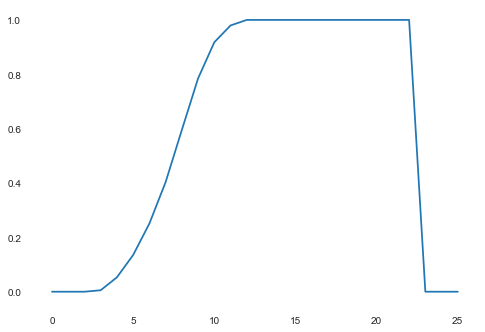

In [518]:
# import pickle as pkl
# with open('pow_curve_fn.pkl','rb') as f:
#     power_curve_fn = pkl.load(f)
from scipy.interpolate import interp1d
power_curve_df = pd.read_csv('data/power-curves.csv')
plt.plot(power_curve_df['IEC - 3'])
power_curve_fn = interp1d(power_curve_df['Speed'],power_curve_df['IEC - 3'],bounds_error=False,fill_value=0)
data_df['pow_curve'] = np.mean(power_curve_fn(load_year('wind',is_in_valid_loc,downsamp)),axis=0)

In [519]:
data_df

,wind,temperature,precipitation,humidity,mo_length,elevation,farm_dist,dist_metric,farm_half_dist0,farm_half_dist1,dist_metric0,dist_metric1,pow_curve
0,5.843258,298.194000,0.010201,30.425873,-0.024716,72.866730,64.790612,0.248979,81.925136,64.790612,0.230247,0.248979,0.330396
1,6.536663,298.101318,0.008926,29.107944,-0.024245,87.635017,74.540910,0.237612,91.751996,74.540910,0.221715,0.237612,0.377907
2,5.350287,298.160278,0.009776,30.143766,0.018635,41.400795,84.368912,0.228002,101.628870,84.368912,0.214286,0.228002,0.269220
3,7.380929,297.016510,0.013602,27.502611,-0.007614,367.817932,7.730174,0.505751,21.267568,7.730174,0.360934,0.505751,0.356881
4,4.657644,298.746155,0.010201,30.943233,-0.015391,-6.719337,23.307804,0.350079,40.396076,23.307804,0.291443,0.350079,0.227405
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,6.623577,281.045044,0.195948,69.696915,0.064796,1697.089600,119.896264,0.202799,119.896264,273.514614,0.202799,0.154054,0.375064
1255,5.454645,282.825500,0.063757,64.288971,0.055065,1185.884521,114.331522,0.206037,114.331522,273.507846,0.206037,0.154055,0.316901
1256,4.735054,281.943237,0.177671,71.308273,0.102071,1446.552612,109.453531,0.209053,109.453531,273.886734,0.209053,0.153984,0.214228
1257,5.660140,285.701813,0.159819,67.286102,0.010140,286.971222,140.531588,0.192343,140.531588,284.908697,0.192343,0.151972,0.321439


## include elevation data

In [406]:
94*63

5922

In [407]:
from wind import calc_elevation
%time elevation = [calc_elevation(*pt) for pt in grid_point_list]
#data_df['elevation'] = np.array(elevation).reshape(coords.shape)[is_in_valid_loc]
data_df['elevation'] = elevation

CPU times: user 32.9 s, sys: 1.96 s, total: 34.9 s
Wall time: 4min 15s


In [304]:
#fnp.save('data/elevation_1520ca.npy',elevation)

## this should be moved to power-vs-wind

cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan


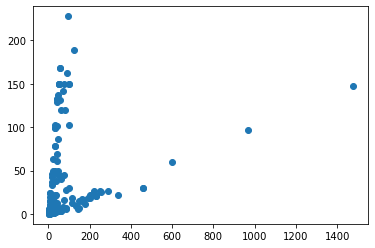

In [15]:
def parse_cap_col(s):
    try:
        return float(str(s)[:-3])
    except:
        return np.nan
#filter by state (state abbrev is always at end of 'Place')
def filter_state(place,state):
    try:
        if place[-1] == ' ':
            print('bad')
        return place[-2:] == state
    except:
        print('cannot parse ',place)
        return False


all_farms = pd.read_csv('data/openei-wind-farm-sites.csv')
ca_farms = all_farms[all_farms['Place'].apply(lambda x: filter_state(x,'CA'))]\
    .copy().reset_index() #make this a new df
plt.scatter(ca_farms['NumberOfUnits'],ca_farms['GeneratingCapacity'].apply(parse_cap_col))

## load wind farm locations

In [6]:
#pd.read_csv('data/openei-wind-farm-sites.csv')[['Facility Name','GeneratingCapacity','NumberOfUnits','Coordinates']].to_csv('data/cal-farms.csv')

In [ ]:
pd.read_csv('data/openei-wind-farm-sites.csv').head()

In [508]:
#swp_df = pd.read_pickle('data/select-wind-power-0607.pkl')
swp_df = pd.read_csv('data/openei-wind-farm-sites.csv')
def parse_coords(in_s):
    try:
        s_list = str(in_s).split(',')
        return  [float(s[:-1]) for s in s_list]
    except:
        print('cannot parse ',in_s)
        return [np.nan,np.nan]
#filter by state (state abbrev is always at end of 'Place')
def filter_state(place,state):
    try:
        if place[-1] == ' ':
            print('bad')
        return place[-2:] == state
    except:
        print('cannot parse ',place)
        return False
swp_df['latitude'], swp_df['longitude'] = list(zip(*swp_df['Coordinates'].apply(parse_coords)))
swp_df = swp_df[swp_df['Place'].apply(lambda x: filter_state(x,'CA'))]\
    .copy().reset_index() #make this a new df
swp_df = swp_df[swp_df['NumberOfUnits'] > 9] #constrain to large farms
swp_df = swp_df[['latitude','longitude']].dropna()
swp_df

cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan
cannot parse  nan


,latitude,longitude
0,35.0861,-118.3533
1,33.7436,-115.9925
3,35.0192,-118.3031
4,35.0192,-118.3031
5,35.0192,-118.3031
...,...,...
160,37.7347,-121.6519
162,34.9994,-118.2911
163,33.9111,-116.5619
164,37.7347,-121.6519


are any wind farms in restricted areas?

In [449]:
restricted_farms = [in_gdf_geo((lat,lon),restricted_gpd)
                    for lat,lon in zip(swp_df['latitude'],swp_df['longitude'])]
np.count_nonzero(restricted_farms)

6

leave out wind farms

In [509]:
swp_half_dfs = [swp_df.iloc[:len(swp_df)//2],swp_df.iloc[len(swp_df)//2:]]

## compute distances to wind farms

In [57]:
from geopy.distance import distance
#is slow for large grids
def min_farm_dist(latlon,swp_df):
    return np.min([distance(latlon,(lat1,lon1)) for lat1,lon1 in zip(swp_df['latitude'],swp_df['longitude'])])

In [510]:
data_df['farm_dist'] = [min_farm_dist(latlon,swp_df).miles for latlon in grid_point_list]
data_df['farm_half_dist0'] = [min_farm_dist(latlon,swp_half_dfs[0]).miles for latlon in grid_point_list]
data_df['farm_half_dist1'] = [min_farm_dist(latlon,swp_half_dfs[1]).miles for latlon in grid_point_list]

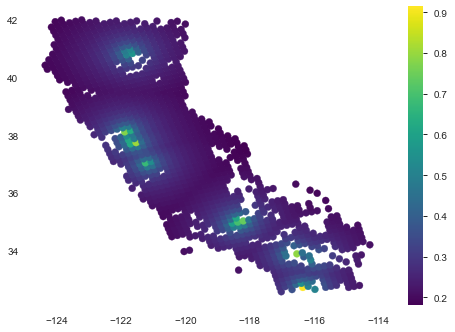

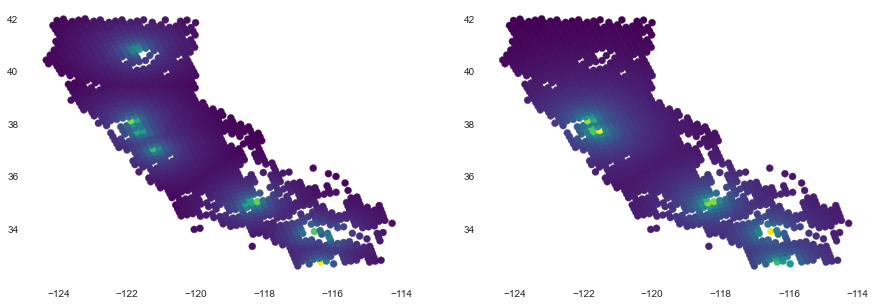

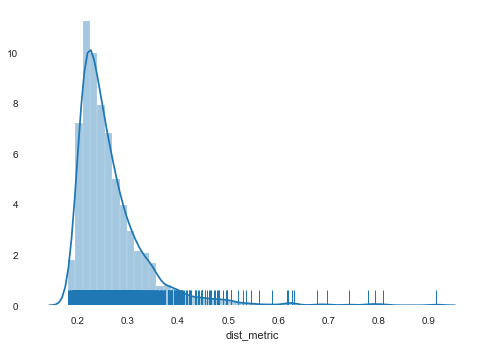

In [511]:
data_df['dist_metric']=1/data_df['farm_dist']**(1/3)
data_df['dist_metric0']=1/data_df['farm_half_dist0']**(1/3)
data_df['dist_metric1']=1/data_df['farm_half_dist1']**(1/3)
plt.scatter([x[1] for x in grid_point_list],[x[0] for x in grid_point_list],
            c=data_df['dist_metric'],cmap='viridis')
plt.colorbar()
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].scatter([x[1] for x in grid_point_list],[x[0] for x in grid_point_list],
            c=data_df['dist_metric0'],cmap='viridis')
axes[1].scatter([x[1] for x in grid_point_list],[x[0] for x in grid_point_list],
            c=data_df['dist_metric1'],cmap='viridis')
plt.show()
sns.distplot(data_df['dist_metric'],rug=True)

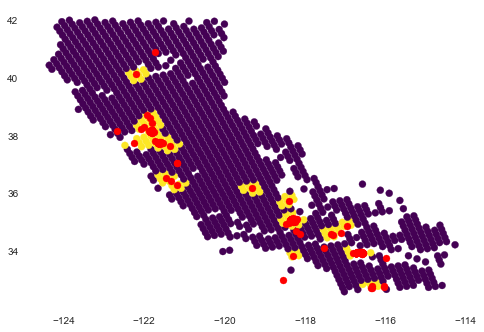

In [453]:
plt.scatter([x[1] for x in grid_point_list],[x[0] for x in grid_point_list],
            c=data_df['dist_metric1'] > 0.4,cmap='viridis')
plt.scatter(swp_df['longitude'],swp_df['latitude'],c='red')

In [77]:
data_df

,wind,temperature,precipitation,humidity,mo_length,farm_dist
0,5.843258,298.194000,0.010201,30.425873,-0.024716,64.790612
1,6.536663,298.101318,0.008926,29.107944,-0.024245,74.540910
2,5.350287,298.160278,0.009776,30.143766,0.018635,84.368912
3,7.380929,297.016510,0.013602,27.502611,-0.007614,7.730174
4,5.255692,298.820099,0.007226,27.666868,-0.040442,14.144260
...,...,...,...,...,...,...
1515,6.623577,281.045044,0.195948,69.696915,0.064796,119.896264
1516,5.454645,282.825500,0.063757,64.288971,0.055065,114.331522
1517,4.735054,281.943237,0.177671,71.308273,0.102071,109.453531
1518,5.660140,285.701813,0.159819,67.286102,0.010140,140.531588


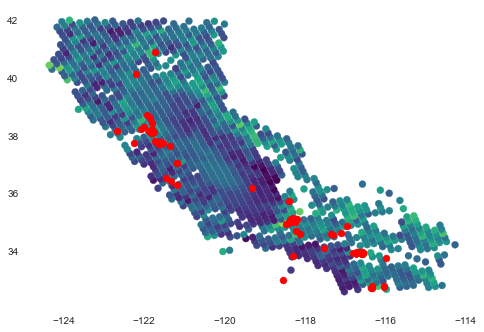

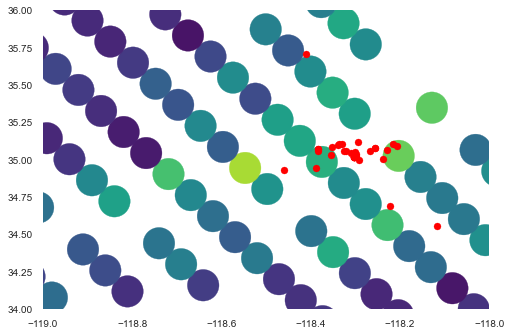

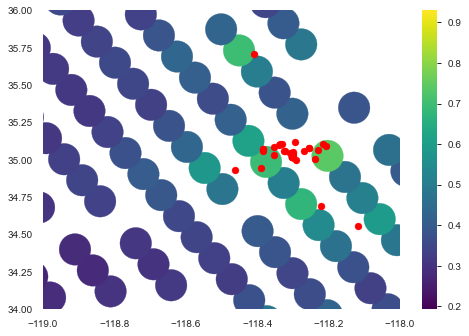

In [507]:
plt.scatter([x[1] for x in grid_point_list],[x[0] for x in grid_point_list],
            c=data_df['wind'],cmap='viridis')
plt.scatter(swp_df['longitude'],swp_df['latitude'],c='red')

plt.show()
plt.scatter([x[1] for x in grid_point_list],[x[0] for x in grid_point_list],
            c=data_df['wind'],cmap='viridis',s=1000)
plt.scatter(swp_df['longitude'],swp_df['latitude'],c='red')
plt.xlim(-119,-118)
plt.ylim(34,36)
plt.show()
plt.scatter([x[1] for x in grid_point_list],[x[0] for x in grid_point_list],
            c=data_df['dist_metric'],cmap='viridis',s=1000)
plt.colorbar()
plt.scatter(swp_df['longitude'],swp_df['latitude'],c='red')
plt.xlim(-119,-118)
plt.ylim(34,36)
plt.show()

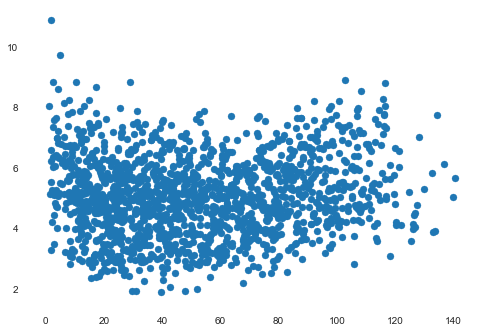

In [246]:
plt.scatter(data_df['farm_dist'],data_df['wind'])

In [415]:
from pandas_profiling import ProfileReport
prof = ProfileReport(data_df)
prof.to_file(output_file='farm_pp_output.html')

exception calling callback for <Future at 0x156d8e9d0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/Users/kook/opt/anaconda3/envs/insight_h5py/lib/python3.8/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/Users/kook/opt/anaconda3/envs/insight_h5py/lib/python3.8/site-packages/joblib/parallel.py", line 347, in __call__
    self.parallel.dispatch_next()
  File "/Users/kook/opt/anaconda3/envs/insight_h5py/lib/python3.8/site-packages/joblib/parallel.py", line 780, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/Users/kook/opt/anaconda3/envs/insight_h5py/lib/python3.8/site-packages/joblib/parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/kook/opt/anaconda3/envs/insight_h5py/lib/python3.8/site-packages/joblib/parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/koo

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

## regression model

In [520]:
features = 'wind,temperature,precipitation,humidity,mo_length,elevation,pow_curve'.split(',')
X = pd.concat([
    data_df[features],
],axis=1)
#y = df['per_turb_cap_frac']
#y = np.log10(data_df['farm_dist'])
y = data_df['dist_metric1']

(array([602., 418., 158.,  44.,  19.,   8.,   3.,   2.,   3.,   2.]),
 array([0.15197241, 0.21756541, 0.28315841, 0.34875141, 0.41434441,
        0.4799374 , 0.5455304 , 0.6111234 , 0.6767164 , 0.74230939,
        0.80790239]),
 <a list of 10 Patch objects>)

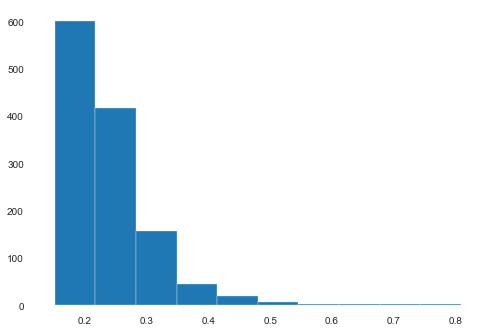

In [513]:
plt.hist(y)

In [339]:
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.inspection import permutation_importance
score_funs = {
    'explained_variance' : explained_variance_score,
    'r2' : r2_score
}
#test a model and print/plot testing results
def test_model(model,X,y, random_state = 0, score = 'explained_variance'):
    score_fun = score_funs[score]
    
    #split the data into training / testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state= random_state)
    #X_train = normalize(X_train)
    #X_test = normalize(X_test)
    #cross validate with f1 scores
    scores = cross_val_score(model,X_train,y_train,scoring = score)

    print('cross validation scores:', scores)
    print('mean,std',np.mean(scores),np.std(scores))
    #fit data and compare scores for training and testing data
    model = model.fit(X_train, y_train)
    
    print("training data")
    y_pred = model.predict(X_train)
    print(score_fun(y_train, y_pred))
    
    print("testing data")
    y_pred = model.predict(X_test)
    print(score_fun(y_test, y_pred))
    
    #plot confusion matrix and permutation importances
#     fig, (cm_ax,pi_ax) = plt.subplots(1,2,figsize=(18,5))

#     plot_confusion_matrix(model,X_test,y_test,ax=cm_ax,normalize='true')
#     cm_ax.set_title('confusion matrix')
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=random_state, n_jobs=1)
    sorted_idx = result.importances_mean.argsort()
    
    fig, ax = plt.subplots(figsize=(18,5))
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    
    fig.tight_layout()
    plt.show()
    
    return model, X_train, X_test, y_train, y_test #returns fitted estimator

cross validation scores: [0.42048715 0.41445944 0.45887324 0.53240066 0.57606703]
mean,std 0.48045750649824814 0.0636511449945726
training data
0.9308774311561036
testing data
0.35450979754827805


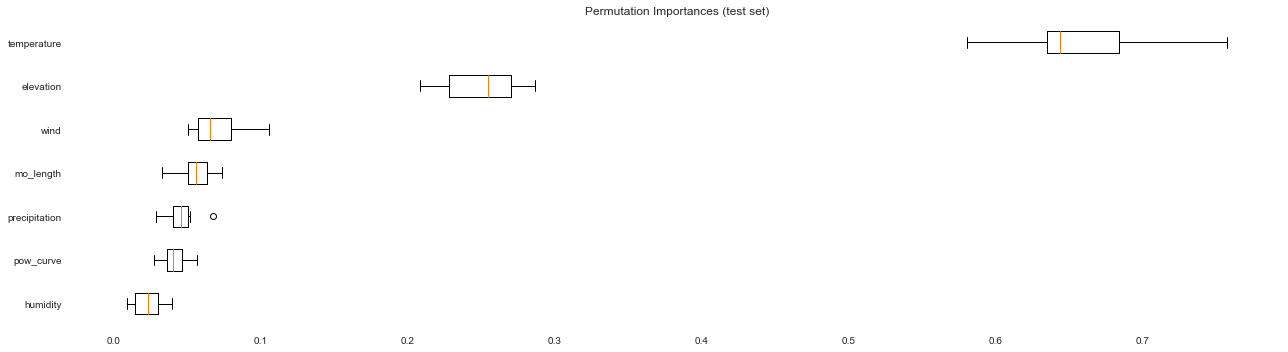

In [521]:
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

model = RandomForestRegressor(n_estimators=2000)
#model = ElasticNetCV()
model, X_train, X_test, y_train, y_test = test_model(model,X,y,score = 'explained_variance',random_state=2)

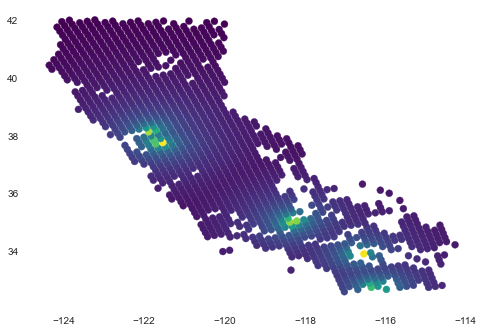

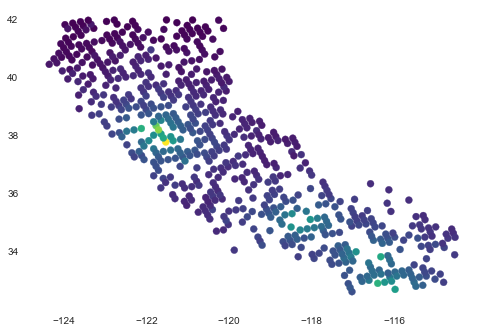

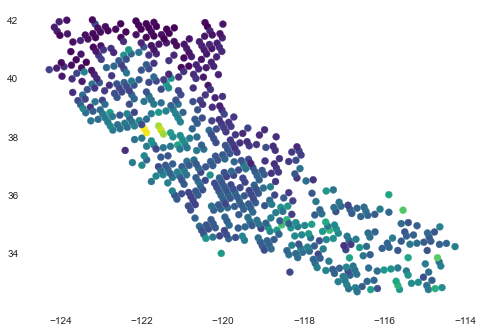

In [522]:
plt.scatter([x[1] for x in grid_point_list],[x[0] for x in grid_point_list],
            c=y,cmap='viridis'); plt.show()
y_pred = model.predict(X_train)
plt.scatter([x[1] for x in np.array(grid_point_list)[X_train.index]],
            [x[0] for x in np.array(grid_point_list)[X_train.index]],
            c=y_pred,cmap='viridis'); plt.show()
y_pred = model.predict(X_test)
plt.scatter([x[1] for x in np.array(grid_point_list)[X_test.index]],
            [x[0] for x in np.array(grid_point_list)[X_test.index]],
            c=y_pred,cmap='viridis'); plt.show()

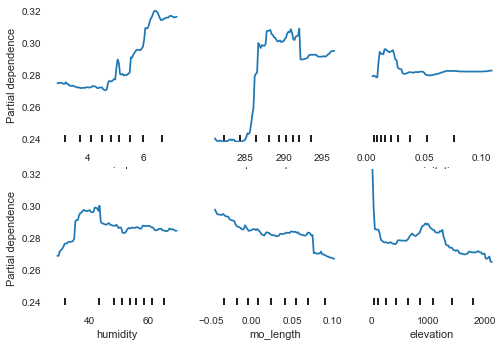

In [478]:
plot_partial_dependence(model,X,[0,1,2,3,4,5])

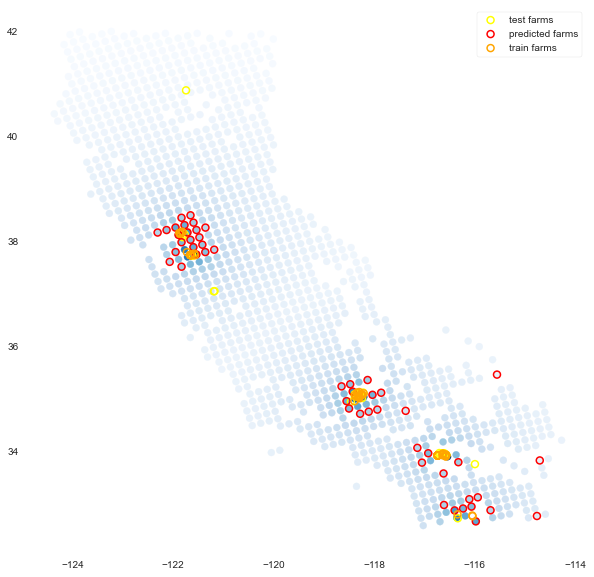

In [523]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter([x[1] for x in grid_point_list],[x[0] for x in grid_point_list],
            c=y,cmap='Blues'); 

y_pred = model.predict(X)
n_predict =50
pred_sort = np.argsort(y_pred)[::-1]
ax.scatter(swp_half_dfs[0]['longitude'],swp_half_dfs[0]['latitude'],
           facecolors='none', edgecolors='yellow',linewidths=1.5,label='test farms')
ax.scatter([x[1] for x in np.array(grid_point_list)[pred_sort][:n_predict]],
            [x[0] for x in np.array(grid_point_list)[pred_sort][:n_predict]],
            facecolors='none', edgecolors='r',linewidths=1.5,label='predicted farms');
ax.scatter(swp_half_dfs[1]['longitude'],swp_half_dfs[1]['latitude'],
           facecolors='none', edgecolors='orange',linewidths=1.5, label = 'train farms')
ax.legend()

# classifier

In [419]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.inspection import permutation_importance, plot_partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report

def test_classifier(model,X,y, random_state = 0, score = 'f1'):
    score_funs = {
    'f1' : f1_score
    }
    score_fun = score_funs[score]
    
    #split the data into training / testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify = y, random_state= random_state)
    #X_train = normalize(X_train)
    #X_test = normalize(X_test)
    #cross validate with f1 scores
    scores = cross_val_score(model,X_train,y_train,scoring = score,cv=3)
    print('cross validation scores:', scores)
    print('mean,std',np.mean(scores),np.std(scores))
    scores = cross_val_score(model,X_train,y_train,scoring = 'precision',cv=3)
    print('cross validation precision:', scores)
    print('mean,std',np.mean(scores),np.std(scores))
    
    #fit data and compare scores for training and testing data
    model = model.fit(X_train, y_train)
    
    print("training data")
    y_pred = model.predict(X_train)
    print(score_fun(y_train, y_pred))
    print(classification_report(y_train,y_pred,labels=[1]))
    print("testing data")
    y_pred = model.predict(X_test)
    print(score_fun(y_test, y_pred))
    print(classification_report(y_test,y_pred,labels=[1]))
    #plot confusion matrix and permutation importances
    fig, axes = plt.subplots(1,3,figsize=(18,5))
    (cm_ax,roc_ax,pi_ax) = axes.ravel()
    plot_confusion_matrix(model,X_test,y_test,ax=cm_ax)
    cm_ax.set_title('confusion matrix')
    #plot_roc_curve(model,X_test,y_test,ax=roc_ax)
    plot_precision_recall_curve(model,X_test,y_test,ax=roc_ax)
    roc_ax.plot([0,1],[0,1],c='red')
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=random_state, n_jobs=1)
    sorted_idx = result.importances_mean.argsort()

    pi_ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X_test.columns[sorted_idx])
    pi_ax.set_title("Permutation Importances (test set)")
    fig.tight_layout()
    plt.show()
    
    #plot_partial_dependence(model,X,[0,1,2,3])
    
    
    return model, (X_train, X_test, y_train, y_test) #returns fitted estimator

In [472]:
from sklearn.preprocessing import Binarizer

features = 'wind,temperature,precipitation,humidity,mo_length,elevation'.split(',')
X = pd.concat([
    data_df[features],
],axis=1)

#y = df['per_turb_cap_frac']
#y = np.log10(data_df['farm_dist'])
#y= -data_df['farm_dist'].to_numpy().reshape(-1,1)
y = data_df['dist_metric1'].to_numpy().reshape(-1,1)
binarizer = Binarizer(threshold=0.4).fit(y)
y = binarizer.transform(y).reshape(-1)
print(np.count_nonzero(y),'/',len(y))
print(np.count_nonzero(y)/len(y))

107 / 1259
0.08498808578236695


In [158]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=50, max_features='sqrt', n_estimators=200)

cross validation scores: [0.33333333 0.1        0.1       ]
mean,std 0.17777777777777778 0.10999438818457405
cross validation precision: [0.66666667 1.         0.33333333]
mean,std 0.6666666666666666 0.2721655269759087
training data
1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        53

   micro avg       1.00      1.00      1.00        53
   macro avg       1.00      1.00      1.00        53
weighted avg       1.00      1.00      1.00        53

testing data
0.16393442622950818
              precision    recall  f1-score   support

           1       0.71      0.09      0.16        54

   micro avg       0.71      0.09      0.16        54
   macro avg       0.71      0.09      0.16        54
weighted avg       0.71      0.09      0.16        54



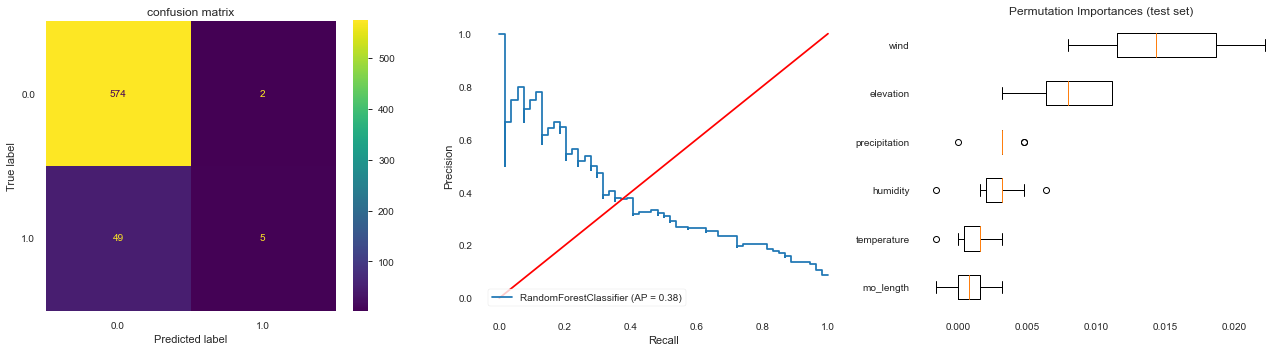

In [473]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB

model = RandomForestClassifier(n_estimators=500)
#model = GaussianProcessClassifier(kernel=RBF(length_scale = 1.0))
#model = GaussianProcessClassifier()
#model = GaussianNB()
#modek = rf_random.best_estimator_
model, (X_train, X_test, y_train, y_test) = test_classifier(model,X,y,random_state=8)

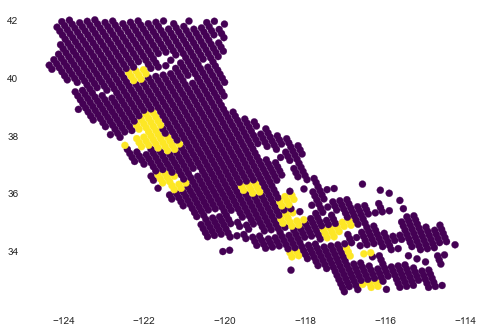

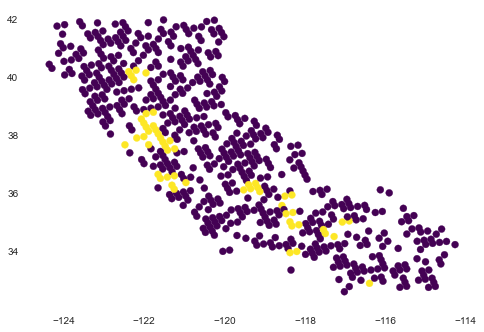

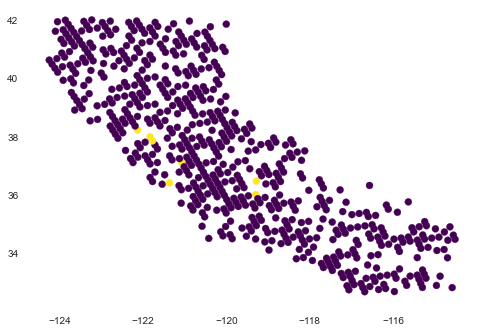

In [474]:
plt.scatter([x[1] for x in grid_point_list],[x[0] for x in grid_point_list],
            c=y,cmap='viridis'); plt.show()
y_pred = model.predict(X_train)
plt.scatter([x[1] for x in np.array(grid_point_list)[X_train.index]],
            [x[0] for x in np.array(grid_point_list)[X_train.index]],
            c=y_pred,cmap='viridis'); plt.show()
y_pred = model.predict(X_test)
plt.scatter([x[1] for x in np.array(grid_point_list)[X_test.index]],
            [x[0] for x in np.array(grid_point_list)[X_test.index]],
            c=y_pred,cmap='viridis'); plt.show()

# hyperparam stuff

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
def make_hyperparam_grid():
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random gridq
    return {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
def hyperparam_search(random_grid,X,y):
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X, y)
    return rf_random

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify = y, random_state= 0)
rf_random = hyperparam_search(make_hyperparam_grid(),X_train,y_train)